In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from os.path import join
import re
import math
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL

# Coleta de Dados

In [89]:
MODULE_PATH = Path().absolute().parent
DATA_PATH = join(MODULE_PATH, "sources/processed")

In [90]:
complete_data = pd.read_csv(join(DATA_PATH, "selected_features_complete_df.csv"))

In [91]:
complete_data["data"] = pd.to_datetime(complete_data["data"])

In [92]:
complete_data = complete_data[complete_data.columns[:10].to_list()]

In [93]:
complete_data.head()

,ano,mes,data,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro
0,2009,1,2009-01-01,0.149600,25.187439,20.299029,76.026835,0,1,0
1,2009,1,2009-01-02,0.305735,24.722086,20.084109,77.689743,0,1,0
2,2009,1,2009-01-03,0.434014,24.058518,19.749311,78.933681,0,1,0
3,2009,1,2009-01-04,0.245052,23.368056,18.715145,77.340627,0,1,0
4,2009,1,2009-01-05,0.201583,23.101135,17.945004,75.597683,0,1,0


# Definição de um Ground Truth

In [94]:
numerical_features = complete_data.columns.tolist()[3:-3]

In [95]:
for feature in numerical_features:
    feature_data = complete_data[feature]
    historical_mean = feature_data.mean()

    complete_data[f"{feature}_anomaly_value"] = feature_data - historical_mean
    complete_data[f"{feature}_anomaly_quartile"] = pd.qcut(complete_data[f"{feature}_anomaly_value"], q=4).astype(str)

In [96]:
complete_data.head()

,ano,mes,data,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro,precipitacao_total_media_anomaly_value,precipitacao_total_media_anomaly_quartile,temperatura_bulbo_hora_media_anomaly_value,temperatura_bulbo_hora_media_anomaly_quartile,temperatura_orvalho_hora_media_anomaly_value,temperatura_orvalho_hora_media_anomaly_quartile,umidade_rel_hora_media_anomaly_value,umidade_rel_hora_media_anomaly_quartile
0,2009,1,2009-01-01,0.149600,25.187439,20.299029,76.026835,0,1,0,-0.019263,"(-0.0907, -0.0174]",1.602733,"(1.398, 4.596]",2.673260,"(2.181, 4.864]",3.465966,"(1.175, 4.361]"
1,2009,1,2009-01-02,0.305735,24.722086,20.084109,77.689743,0,1,0,0.136872,"(0.071, 0.584]",1.137380,"(0.46, 1.398]",2.458339,"(2.181, 4.864]",5.128873,"(4.361, 12.287]"
2,2009,1,2009-01-03,0.434014,24.058518,19.749311,78.933681,0,1,0,0.265151,"(0.071, 0.584]",0.473813,"(0.46, 1.398]",2.123542,"(0.579, 2.181]",6.372812,"(4.361, 12.287]"
3,2009,1,2009-01-04,0.245052,23.368056,18.715145,77.340627,0,1,0,0.076189,"(0.071, 0.584]",-0.216650,"(-1.335, 0.46]",1.089376,"(0.579, 2.181]",4.779758,"(4.361, 12.287]"
4,2009,1,2009-01-05,0.201583,23.101135,17.945004,75.597683,0,1,0,0.032720,"(-0.0174, 0.071]",-0.483571,"(-1.335, 0.46]",0.319235,"(-2.137, 0.579]",3.036813,"(1.175, 4.361]"


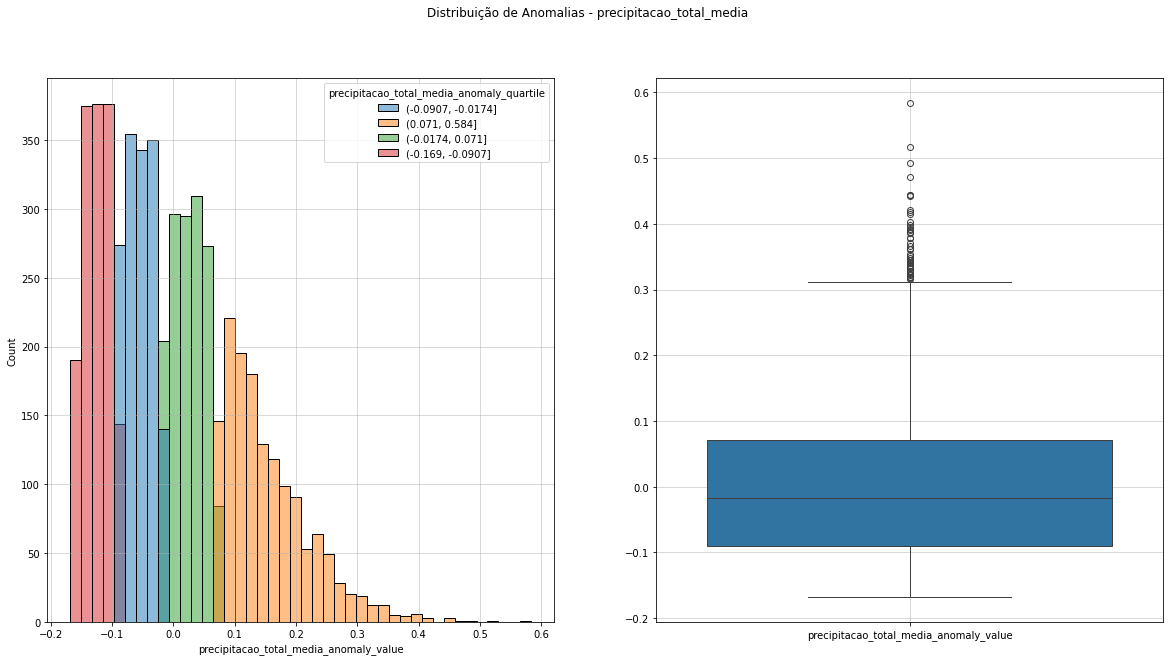

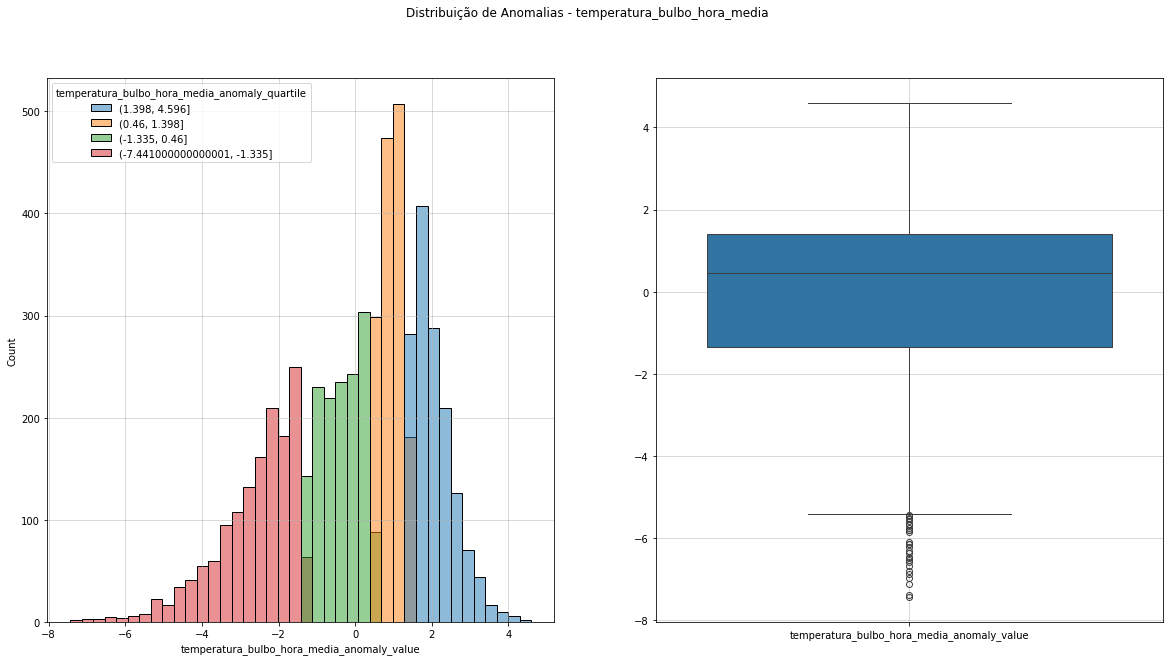

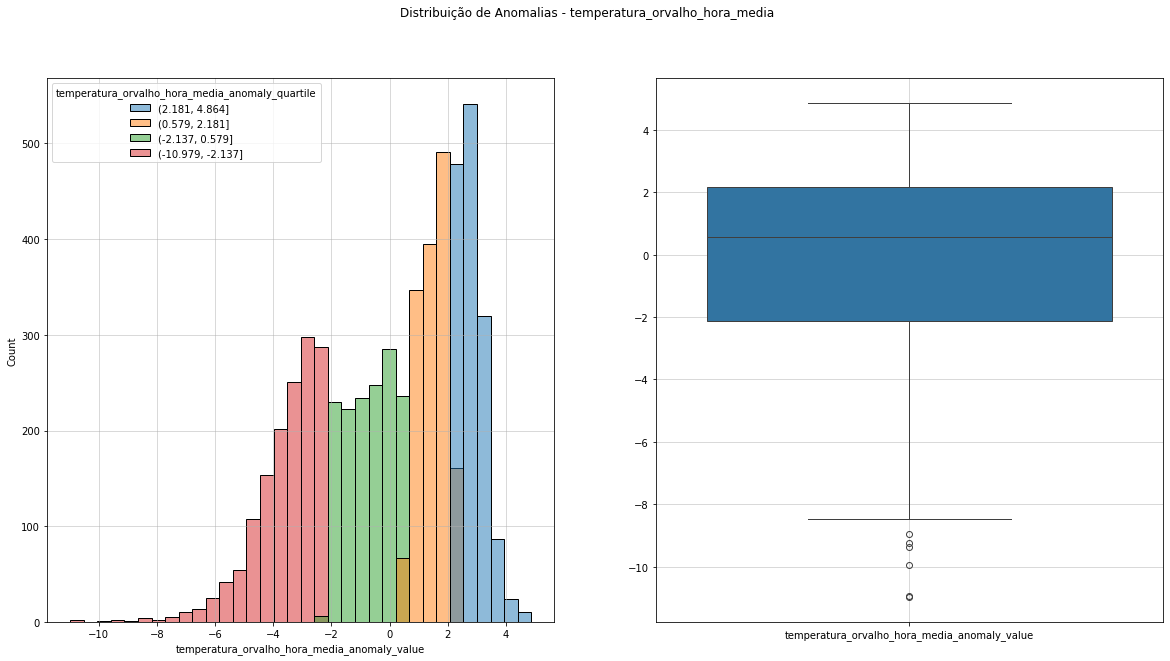

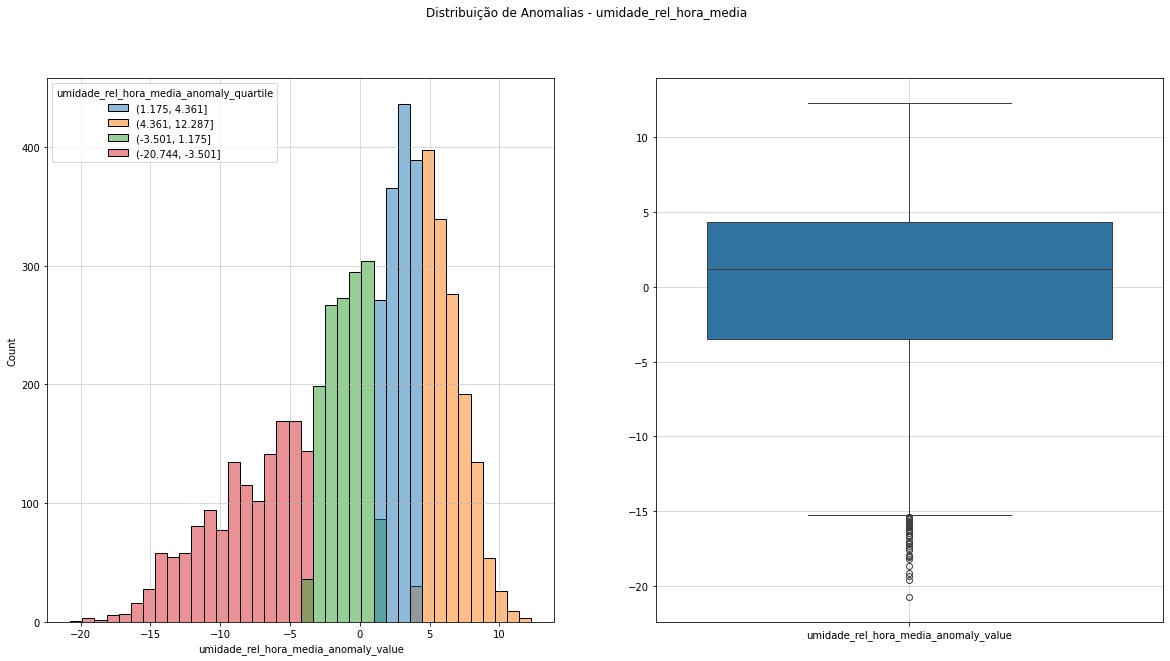

In [97]:
for feature in numerical_features:
    feature_anomaly_data = complete_data[[f"{feature}_anomaly_value", f"{feature}_anomaly_quartile"]]
    #feature_anomaly_quartiles = complete_data[f"{feature}_anomaly_quartile"].values
    # feature_anomaly_data_std = feature_anomaly_data / feature_anomaly_data.std()

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    sns.histplot(
        feature_anomaly_data, 
        x=f"{feature}_anomaly_value", 
        # kde=True, 
        hue=f"{feature}_anomaly_quartile", 
        ax=axes[0])
    sns.boxplot(feature_anomaly_data, ax=axes[1])
    plt.suptitle(f"Distribuição de Anomalias - {feature}")
    axes[0].grid(True, alpha=0.6)
    axes[1].grid(True, alpha=0.6)
    plt.show()

In [114]:
# precipitação: X > 0.3
# temperatura_bulbo: X < -5; X > 3
# temperatura_orvalho: X < -6; X > 3
# umidade: X < -15; X > 10

anomalies_map = {
    "precipitacao_total_media": complete_data["precipitacao_total_media_anomaly_value"] >= 0.3,
    "temperatura_bulbo_hora_media": 
            (complete_data["temperatura_bulbo_hora_media_anomaly_value"] <= -3) |
            (complete_data["temperatura_bulbo_hora_media_anomaly_value"] >= 2.75),
    "temperatura_orvalho_hora_media": 
            (complete_data["temperatura_orvalho_hora_media_anomaly_value"] <= -4.5) |
            (complete_data["temperatura_orvalho_hora_media_anomaly_value"] >= 3.5),
    "umidade_rel_hora_media": 
            (complete_data["umidade_rel_hora_media_anomaly_value"] <= -10) |
            (complete_data["umidade_rel_hora_media_anomaly_value"] >= 8)}

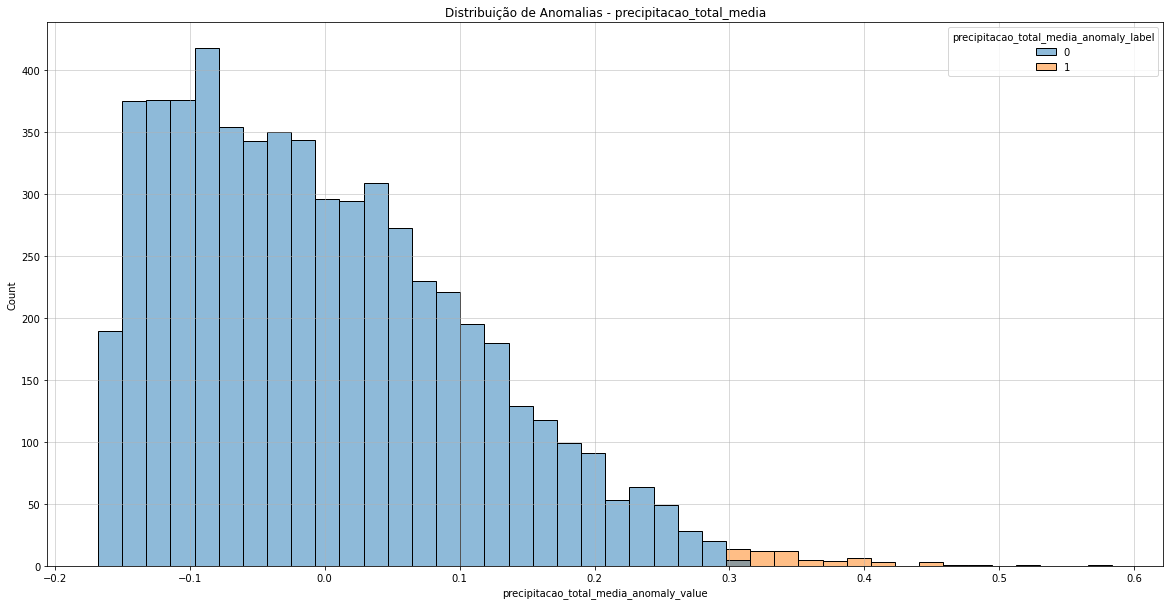

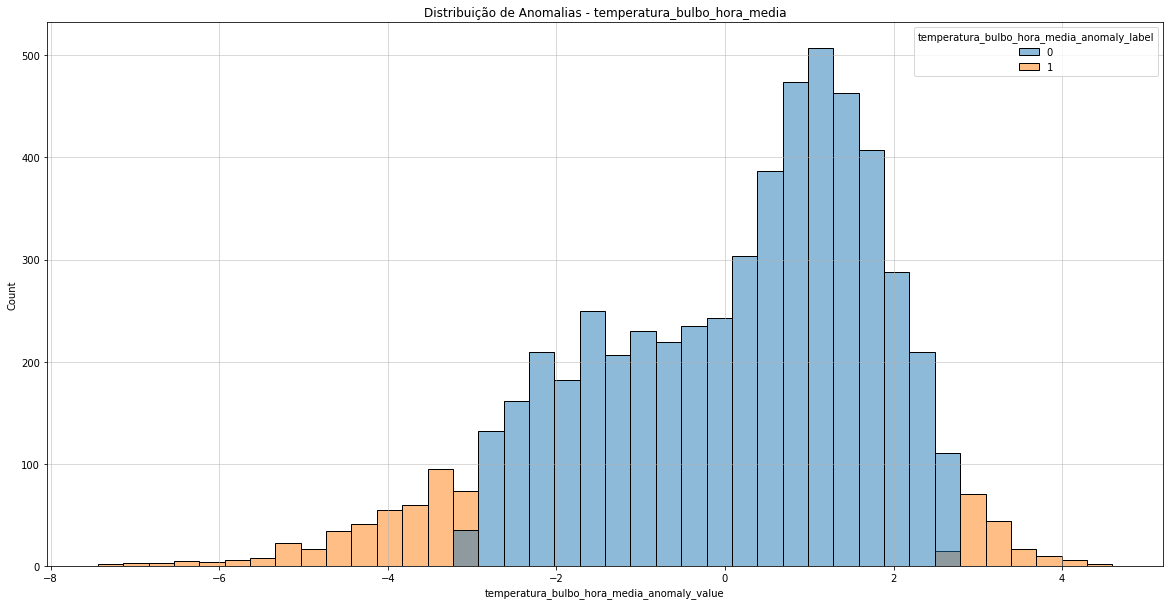

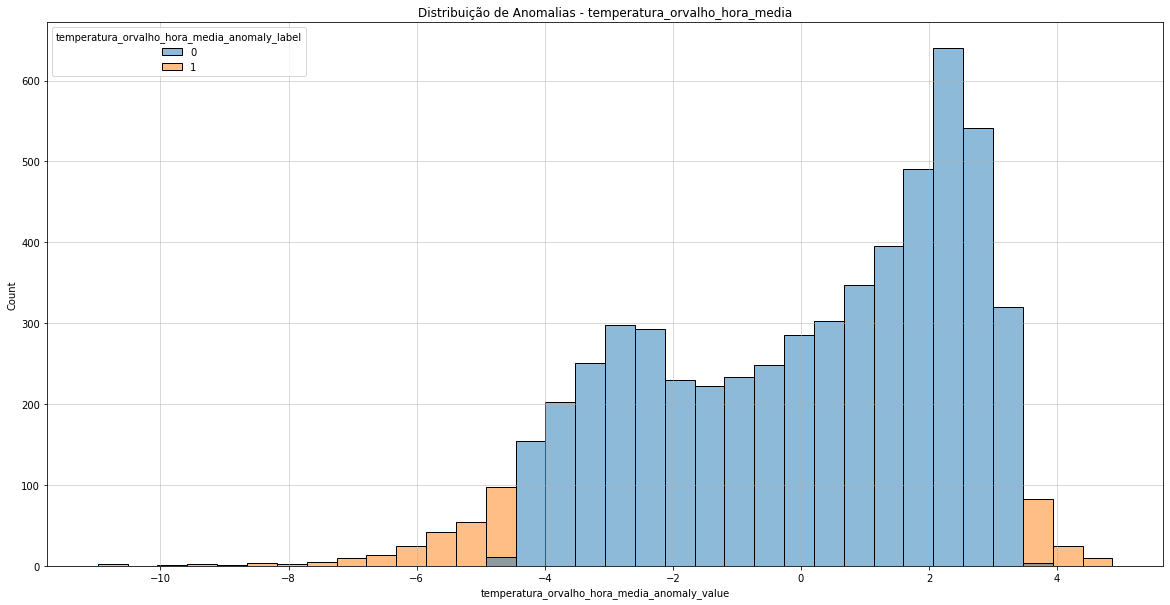

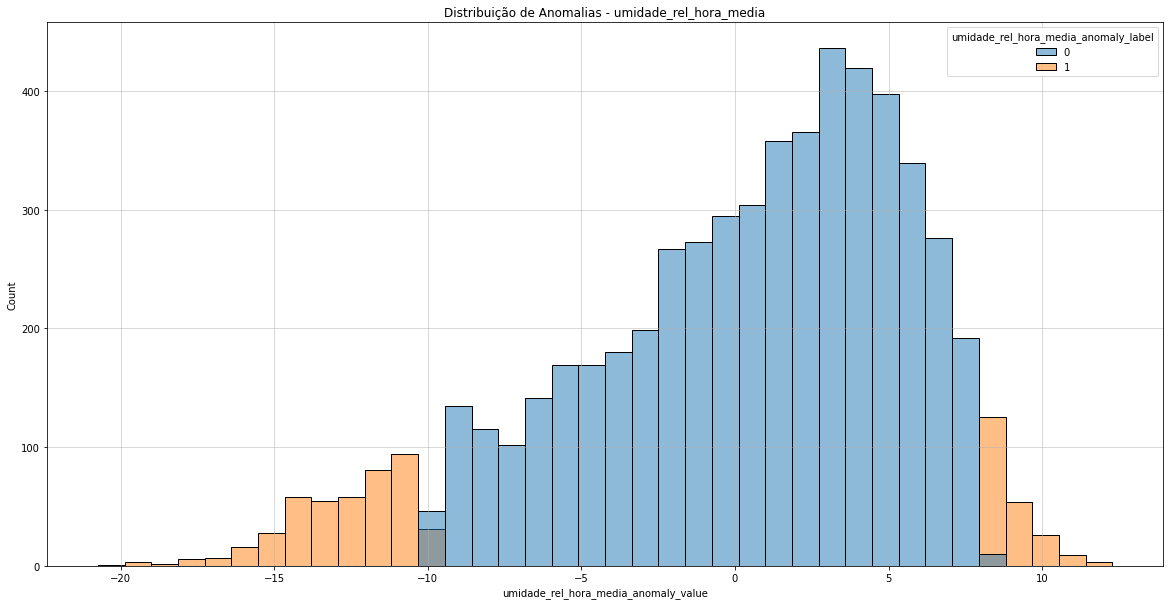

In [115]:
for feature, mask in anomalies_map.items():

    complete_data[f"{feature}_anomaly_label"] = 0
    complete_data.loc[mask, f"{feature}_anomaly_label"] = 1

    feature_anomaly_data = complete_data[[f"{feature}_anomaly_value", f"{feature}_anomaly_label"]]

    fig, ax = plt.subplots(figsize=(20, 10))
    sns.histplot(
        feature_anomaly_data, 
        x=f"{feature}_anomaly_value", 
        hue=f"{feature}_anomaly_label", 
        ax=ax)
    plt.title(f"Distribuição de Anomalias - {feature}")
    plt.grid(True, alpha=0.6)
    plt.show()

In [76]:
complete_data

,ano,mes,data,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro,...,temperatura_orvalho_hora_media_anomaly_value,umidade_rel_hora_media_anomaly_value,precipitacao_total_media_anomaly_quartile,temperatura_bulbo_hora_media_anomaly_quartile,temperatura_orvalho_hora_media_anomaly_quartile,umidade_rel_hora_media_anomaly_quartile,precipitacao_total_media_anomaly_value_anomaly_label,temperatura_bulbo_hora_media_anomaly_value_anomaly_label,temperatura_orvalho_hora_media_anomaly_label,umidade_rel_hora_media_anomaly_label
0,2009,1,2009-01-01,0.149600,25.187439,20.299029,76.026835,0,1,0,...,2.673260,3.465966,"(-0.0907, -0.0174]","(1.398, 4.596]","(2.181, 4.864]","(1.175, 4.361]",0,0,1,1
1,2009,1,2009-01-02,0.305735,24.722086,20.084109,77.689743,0,1,0,...,2.458339,5.128873,"(0.071, 0.584]","(0.46, 1.398]","(2.181, 4.864]","(4.361, 12.287]",0,0,1,1
2,2009,1,2009-01-03,0.434014,24.058518,19.749311,78.933681,0,1,0,...,2.123542,6.372812,"(0.071, 0.584]","(0.46, 1.398]","(0.579, 2.181]","(4.361, 12.287]",0,0,1,1
3,2009,1,2009-01-04,0.245052,23.368056,18.715145,77.340627,0,1,0,...,1.089376,4.779758,"(0.071, 0.584]","(-1.335, 0.46]","(0.579, 2.181]","(4.361, 12.287]",0,0,1,1
4,2009,1,2009-01-05,0.201583,23.101135,17.945004,75.597683,0,1,0,...,0.319235,3.036813,"(-0.0174, 0.071]","(-1.335, 0.46]","(-2.137, 0.579]","(1.175, 4.361]",0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5839,2024,12,2024-12-27,0.294394,24.739027,19.652470,75.742225,0,1,0,...,2.026701,3.181356,"(0.071, 0.584]","(0.46, 1.398]","(0.579, 2.181]","(1.175, 4.361]",0,0,1,1
5840,2024,12,2024-12-28,0.165835,25.208879,19.895573,74.673927,0,1,0,...,2.269803,2.113058,"(-0.0174, 0.071]","(1.398, 4.596]","(2.181, 4.864]","(1.175, 4.361]",0,0,1,1
5841,2024,12,2024-12-29,0.294873,24.976626,19.863624,75.193482,0,1,0,...,2.237855,2.632613,"(0.071, 0.584]","(0.46, 1.398]","(2.181, 4.864]","(1.175, 4.361]",0,0,1,1
5842,2024,12,2024-12-30,0.157844,25.026208,19.804128,74.833682,0,1,0,...,2.178359,2.272813,"(-0.0174, 0.071]","(1.398, 4.596]","(0.579, 2.181]","(1.175, 4.361]",0,0,1,1
